<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Wealth Distribution Dynamics

## Contents

- [Wealth Distribution Dynamics](#Wealth-Distribution-Dynamics)  
  - [Overview](#Overview)  
  - [Lorenz Curves and the Gini Coefficient](#Lorenz-Curves-and-the-Gini-Coefficient)  
  - [A Model of Wealth Dynamics](#A-Model-of-Wealth-Dynamics)  
  - [Implementation](#Implementation)  
  - [Applications](#Applications)  
  - [Exercises](#Exercises)  


In addition to what’s in Anaconda, this lecture will need the following libraries:

In [1]:
!pip install --upgrade quantecon

Requirement already up-to-date: quantecon in c:\users\harve\appdata\roaming\python\python36\site-packages (0.4.6)


## Overview

This notebook gives an introduction to wealth distribution dynamics, with a
focus on

- modeling and computing the wealth distribution via simulation,  
- measures of inequality such as the Lorenz curve and Gini coefficient, and  
- how inequality is affected by the properties of wage income and returns on assets.  


One interesting property of the wealth distribution we discuss is Pareto
tails.

The wealth distribution in many countries exhibits a Pareto tail

- See [this lecture](heavy_tails.ipynb) for a definition.  
- For a review of the empirical evidence, see, for example, [[BB18]](zreferences.ipynb#benhabib2018skewed).  


This is consistent with high concentration of wealth amongst the richest households.

It also gives us a way to quantify such concentration, in terms of the tail index.

One question of interest is whether or not we can replicate Pareto tails from a relatively simple model.

### A Note on Assumptions

The evolution of wealth for any given household depends on their
savings behavior.

Modeling such behavior will form an important part of this lecture series.

However, in this particular lecture, we will be content with rather ad hoc (but plausible) savings rules.

We do this to more easily explore the implications of different specifications of income dynamics and investment returns.

At the same time, all of the techniques discussed here can be plugged into models that use optimization to obtain savings rules.

We will use the following imports.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import quantecon as qe
from numba import njit, jitclass, float64, prange

## Lorenz Curves and the Gini Coefficient

Before we investigate wealth dynamics, we briefly review some measures of
inequality.

### Lorenz Curves

One popular graphical measure of inequality is the [Lorenz curve](https://en.wikipedia.org/wiki/Lorenz_curve).

The package [QuantEcon.py](https://github.com/QuantEcon/QuantEcon.py), already imported above, contains a function to compute Lorenz curves.

To illustrate, suppose that

In [3]:
n = 10_000                      # size of sample
w = np.exp(np.random.randn(n))  # lognormal draws

is data representing the wealth of 10,000 households.

We can compute and plot the Lorenz curve as follows:

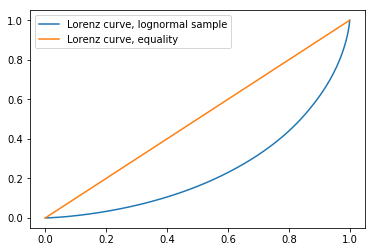

In [4]:
f_vals, l_vals = qe.lorenz_curve(w)

fig, ax = plt.subplots()
ax.plot(f_vals, l_vals, label='Lorenz curve, lognormal sample')
ax.plot(f_vals, f_vals, label='Lorenz curve, equality')
ax.legend()
plt.show()

This curve can be understood as follows: if point $ (x,y) $ lies on the curve, it means that, collectively, the bottom $ (100x)\% $ of the population holds $ (100y)\% $ of the wealth.

The “equality” line is the 45 degree line (which might not be exactly 45
degrees in the figure, depending on the aspect ratio).

A sample that produces this line exhibits perfect equality.

The other line in the figure is the Lorenz curve for the lognormal sample, which deviates significantly from perfect equality.

For example, the bottom 80% of the population holds around 40% of total wealth.

Here is another example, which shows how the Lorenz curve shifts as the
underlying distribution changes.

We generate 10,000 observations using the Pareto distribution with a range of
parameters, and then compute the Lorenz curve corresponding to each set of
observations.

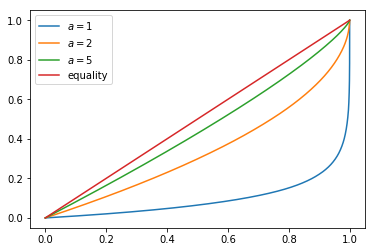

In [5]:
a_vals = (1, 2, 5)              # Pareto tail index
n = 10_000                      # size of each sample
fig, ax = plt.subplots()
for a in a_vals:
    u = np.random.uniform(size=n)
    y = u**(-1/a)               # distributed as Pareto with tail index a
    f_vals, l_vals = qe.lorenz_curve(y)
    ax.plot(f_vals, l_vals, label=f'$a = {a}$')
ax.plot(f_vals, f_vals, label='equality')
ax.legend()
plt.show()

You can see that, as the tail parameter of the Pareto distribution increases, inequality decreases.

This is to be expected, because a higher tail index implies less weight in the tail of the Pareto distribution.

### The Gini Coefficient

The definition and interpretation of the Gini coefficient can be found on the corresponding [Wikipedia page](https://en.wikipedia.org/wiki/Gini_coefficient).

A value of 0 indicates perfect equality (corresponding the case where the
Lorenz curve matches the 45 degree line) and a value of 1 indicates complete
inequality (all wealth held by the richest household).

The [QuantEcon.py](https://github.com/QuantEcon/QuantEcon.py) library contains a function to calculate the Gini coefficient.

We can test it on the Weibull distribution with parameter $ a $, where the Gini coefficient is known to be

$$
G = 1 - 2^{-1/a}
$$

Let’s see if the Gini coefficient computed from a simulated sample matches
this at each fixed value of $ a $.

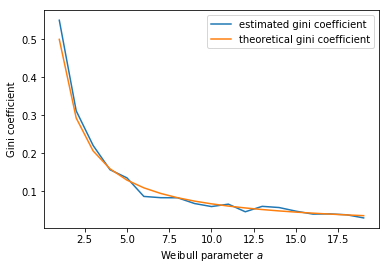

In [6]:
a_vals = range(1, 20)
ginis = []
ginis_theoretical = []
n = 100

fig, ax = plt.subplots()
for a in a_vals:
    y = np.random.weibull(a, size=n)
    ginis.append(qe.gini_coefficient(y))
    ginis_theoretical.append(1 - 2**(-1/a))
ax.plot(a_vals, ginis, label='estimated gini coefficient')
ax.plot(a_vals, ginis_theoretical, label='theoretical gini coefficient')
ax.legend()
ax.set_xlabel("Weibull parameter $a$")
ax.set_ylabel("Gini coefficient")
plt.show()

The simulation shows that the fit is good.

## A Model of Wealth Dynamics

Having discussed inequality measures, let us now turn to wealth dynamics.

The model we will study is


<a id='equation-wealth-dynam-ah'></a>
$$
w_{t+1} = (1 + r_{t+1}) s(w_t) + y_{t+1} \tag{1}
$$

where

- $ w_t $ is wealth at time $ t $ for a given household,  
- $ r_t $ is the rate of return of financial assets,  
- $ y_t $ is current non-financial (e.g., labor) income and  
- $ s(w_t) $ is current wealth net of consumption  


Letting $ \{z_t\} $ be a correlated state process of the form

$$
z_{t+1} = a z_t + b + \sigma_z \epsilon_{t+1}
$$

we’ll assume that

$$
R_t := 1 + r_t = c_r \exp(z_t) + \exp(\mu_r + \sigma_r \xi_t)
$$

and

$$
y_t = c_y \exp(z_t) + \exp(\mu_y + \sigma_y \zeta_t)
$$

Here $ \{ (\epsilon_t, \xi_t, \zeta_t) \} $ is IID and standard
normal in $ \mathbb R^3 $.

The value of $ c_r $ should be close to zero, since rates of return
on assets do not exhibit large trends.

When we simulate a population of households, we will assume all shocks are idiosyncratic (i.e.,  specific to individual households and independent across them).

Regarding the savings function $ s $, our default model will be


<a id='equation-sav-ah'></a>
$$
s(w) = s_0 w \cdot \mathbb 1\{w \geq \hat w\} \tag{2}
$$

where $ s_0 $ is a positive constant.

Thus, for $ w < \hat w $, the household saves nothing. For
$ w \geq \bar w $, the household saves a fraction $ s_0 $ of
their wealth.

We are using something akin to a fixed savings rate model, while
acknowledging that low wealth households tend to save very little.

## Implementation

Here’s some type information to help Numba.

In [7]:
wealth_dynamics_data = [
    ('w_hat',  float64),    # savings parameter
    ('s_0',    float64),    # savings parameter
    ('c_y',    float64),    # labor income parameter
    ('μ_y',    float64),    # labor income paraemter
    ('σ_y',    float64),    # labor income parameter
    ('c_r',    float64),    # rate of return parameter
    ('μ_r',    float64),    # rate of return parameter
    ('σ_r',    float64),    # rate of return parameter
    ('a',      float64),    # aggregate shock parameter
    ('b',      float64),    # aggregate shock parameter
    ('σ_z',    float64),    # aggregate shock parameter
    ('z_mean', float64),    # mean of z process
    ('z_var', float64),     # variance of z process
    ('y_mean', float64),    # mean of y process
    ('R_mean', float64)     # mean of R process
]

Here’s a class that stores instance data and implements methods that update
the aggregate state and household wealth.

In [8]:
@jitclass(wealth_dynamics_data)
class WealthDynamics:

    def __init__(self,
                 w_hat=1.0,
                 s_0=0.75,
                 c_y=1.0,
                 μ_y=1.0,
                 σ_y=0.2,
                 c_r=0.05,
                 μ_r=0.1,
                 σ_r=0.5,
                 a=0.5,
                 b=0.0,
                 σ_z=0.1):

        self.w_hat, self.s_0 = w_hat, s_0
        self.c_y, self.μ_y, self.σ_y = c_y, μ_y, σ_y
        self.c_r, self.μ_r, self.σ_r = c_r, μ_r, σ_r
        self.a, self.b, self.σ_z = a, b, σ_z

        # Record stationary moments
        self.z_mean = b / (1 - a)
        self.z_var = σ_z**2 / (1 - a**2)
        exp_z_mean = np.exp(self.z_mean + self.z_var / 2)
        self.R_mean = c_r * exp_z_mean + np.exp(μ_r + σ_r**2 / 2)
        self.y_mean = c_y * exp_z_mean + np.exp(μ_y + σ_y**2 / 2)

        # Test a stability condition that ensures wealth does not diverge
        # to infinity.
        α = self.R_mean * self.s_0
        if α >= 1:
            raise ValueError("Stability condition failed.")

    def parameters(self):
        """
        Collect and return parameters.
        """
        parameters = (self.w_hat, self.s_0,
                      self.c_y, self.μ_y, self.σ_y,
                      self.c_r, self.μ_r, self.σ_r,
                      self.a, self.b, self.σ_z)
        return parameters

    def update_states(self, w, z):
        """
        Update one period, given current wealth w and persistent
        state z.
        """

        # Simplify names
        params = self.parameters()
        w_hat, s_0, c_y, μ_y, σ_y, c_r, μ_r, σ_r, a, b, σ_z = params
        zp = a * z + b + σ_z * np.random.randn()

        # Update wealth
        y = c_y * np.exp(zp) + np.exp(μ_y + σ_y * np.random.randn())
        wp = y
        if w >= w_hat:
            R = c_r * np.exp(zp) + np.exp(μ_r + σ_r * np.random.randn())
            wp += R * s_0 * w
        return wp, zp

Here’s function to simulate the time series of wealth for in individual households.

In [9]:
@njit
def wealth_time_series(wdy, w_0, n):
    """
    Generate a single time series of length n for wealth given
    initial value w_0.

    The initial persistent state z_0 for each household is drawn from
    the stationary distribution of the AR(1) process.

        * wdy: an instance of WealthDynamics
        * w_0: scalar
        * n: int


    """
    z = wdy.z_mean + np.sqrt(wdy.z_var) * np.random.randn()
    w = np.empty(n)
    w[0] = w_0
    for t in range(n-1):
        w[t+1], z = wdy.update_states(w[t], z)
    return w

Now here’s function to simulate a cross section of households forward in time.

Note the use of parallelization to speed up computation.

In [10]:
@njit(parallel=True)
def update_cross_section(wdy, w_distribution, shift_length=500):
    """
    Shifts a cross-section of household forward in time

    * wdy: an instance of WealthDynamics
    * w_distribution: array_like, represents current cross-section

    Takes a current distribution of wealth values as w_distribution
    and updates each w_t in w_distribution to w_{t+j}, where
    j = shift_length.

    Returns the new distribution.

    """
    new_distribution = np.empty_like(w_distribution)

    # Update each household
    for i in prange(len(new_distribution)):
        z = wdy.z_mean + np.sqrt(wdy.z_var) * np.random.randn()
        w = w_distribution[i]
        for t in range(shift_length-1):
            w, z = wdy.update_states(w, z)
        new_distribution[i] = w
    return new_distribution

Parallelization is very effective in the function above because the time path
of each household can be calculated independently once the path for the
aggregate state is known.

## Applications

Let’s try simulating the model at different parameter values and investigate
the implications for the wealth distribution.

### Time Series

Let’s look at the wealth dynamics of an individual household.

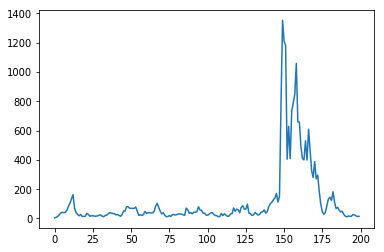

In [11]:
wdy = WealthDynamics( w_hat=1.0,
                 s_0=0.75,
                 c_y=1.0,
                 μ_y=1.0,
                 σ_y=0.2,
                 c_r=0.05,
                 μ_r=0.1,
                 σ_r=0.5,
                 a=0.5,
                 b=0.0,
                 σ_z=0.1)

ts_length = 200
w = wealth_time_series(wdy, wdy.y_mean, ts_length)

fig, ax = plt.subplots()
ax.plot(w)
plt.show()

Notice the large spikes in wealth over time.

Such spikes are similar to what we observed in time series when [we studied Kesten processes](kesten_processes.ipynb).

### Inequality Measures

Let’s look at how inequality varies with returns on financial assets.

The next function generates a cross section and then computes the Lorenz
curve and Gini coefficient.

In [12]:
def generate_lorenz_and_gini(wdy, num_households=100_000, T=500):
    """
    Generate the Lorenz curve data and gini coefficient corresponding to a
    WealthDynamics mode by simulating num_households forward to time T.
    """
    ψ_0 = np.ones(num_households) * wdy.y_mean
    z_0 = wdy.z_mean

    ψ_star = update_cross_section(wdy, ψ_0, shift_length=T)
    return qe.gini_coefficient(ψ_star), qe.lorenz_curve(ψ_star)

Now we investigate how the Lorenz curves associated with the wealth distribution change as return to savings varies.

The code below plots Lorenz curves for three different values of $ \mu_r $.

If you are running this yourself, note that it will take one or two minutes to execute.

This is unavoidable because we are executing a CPU intensive task.

In fact the code, which is JIT compiled and parallelized, runs extremely fast relative to the number of computations.

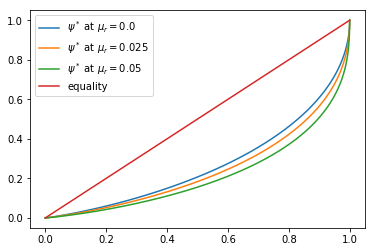

In [13]:
fig, ax = plt.subplots()
μ_r_vals = (0.0, 0.025, 0.05)
gini_vals = []

for μ_r in μ_r_vals:
    wdy = WealthDynamics(w_hat=1.0,
                 s_0=0.75,
                 c_y=1.0,
                 μ_y=1.0,
                 σ_y=0.2,
                 c_r=0.05,
                 μ_r=μ_r,
                 σ_r=0.5,
                 a=0.5,
                 b=0.0,
                 σ_z=0.1)
    gv, (f_vals, l_vals) = generate_lorenz_and_gini(wdy)
    ax.plot(f_vals, l_vals, label=f'$\psi^*$ at $\mu_r = {μ_r:0.2}$')
    gini_vals.append(gv)

ax.plot(f_vals, f_vals, label='equality')
ax.legend(loc="upper left")
plt.show()

The Lorenz curve shifts downwards as returns on financial income rise, indicating a rise in inequality.

We will look at this again via the Gini coefficient immediately below, but
first consider the following image of our system resources when the code above
is executing:


<a id='htop-again'></a>
![_static/lecture_specific/wealth_dynamics/htop_again.png](_static/lecture_specific/wealth_dynamics/htop_again.png)  
Notice how effectively Numba has implemented multithreading for this routine:
all 8 CPUs on our workstation are running at maximum capacity (even though
four of them are virtual).

Since the code is both efficiently JIT compiled and fully parallelized, it’s
close to impossible to make this sequence of tasks run faster without changing
hardware.

Now let’s check the Gini coefficient.

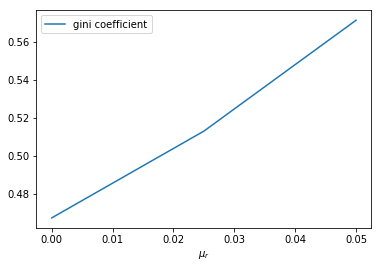

In [14]:
fig, ax = plt.subplots()
ax.plot(μ_r_vals, gini_vals, label='gini coefficient')
ax.set_xlabel("$\mu_r$")
ax.legend()
plt.show()

Once again, we see that inequality increases as returns on financial income
rise.

Let’s finish this section by investigating what happens when we change the
volatility term $ \sigma_r $ in financial returns.

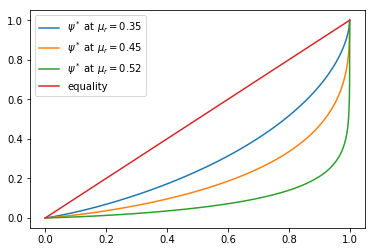

In [15]:
fig, ax = plt.subplots()
σ_r_vals = (0.35, 0.45, 0.52)
gini_vals = []

for σ_r in σ_r_vals:
    wdy = WealthDynamics(w_hat=1.0,
                 s_0=0.75,
                 c_y=1.0,
                 μ_y=1.0,
                 σ_y=0.2,
                 c_r=0.05,
                 μ_r=0.1,
                 σ_r=σ_r,
                 a=0.5,
                 b=0.0,
                 σ_z=0.1)
    gv, (f_vals, l_vals) = generate_lorenz_and_gini(wdy)
    ax.plot(f_vals, l_vals, label=f'$\psi^*$ at $\mu_r = {σ_r:0.2}$')
    gini_vals.append(gv)

ax.plot(f_vals, f_vals, label='equality')
ax.legend(loc="upper left")
plt.show()

We see that greater volatility has the effect of increasing inequality in this model.

## Exercises

### Exercise 1

For a wealth or income distribution with Pareto tail, a higher tail index suggests lower inequality.

Indeed, it is possible to prove that the Gini coefficient of the Pareto
distribution with tail index $ a $ is $ 1/(2a - 1) $.

To the extent that you can, confirm this by simulation.

In particular, generate a plot of the Gini coefficient against the tail index
using both the theoretical value just given and the value computed from a sample via `qe.gini_coefficient`.

For the values of the tail index, use `a_vals = np.linspace(1, 10, 25)`.

Use sample of size 1,000 for each $ a $ and the sampling method for generating Pareto draws employed in the discussion of Lorenz curves for the Pareto distribution.

To the extend that you can, interpret the monotone relationship between the
Gini index and $ a $.

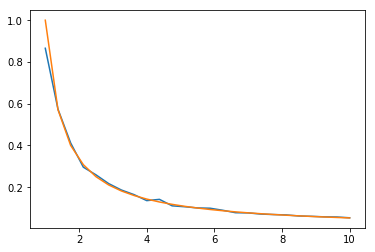

In [16]:
a_vals = np.linspace(1, 10, 25)
ginis = np.empty(len(a_vals))

samp_size= 1000

fig, ax = plt.subplots()

for i,a in enumerate(a_vals):
    y = np.random.uniform(size=samp_size)**(-1/a)
    ginis[i]=qe.gini_coefficient(y)

    
ax.plot(a_vals, ginis)
ax.plot(a_vals, 1/(2*a_vals - 1))
plt.show()

### Exercise 2

The wealth process [(1)](#equation-wealth-dynam-ah) is similar to a [Kesten process](kesten_processes.ipynb).

This is because, according to [(2)](#equation-sav-ah), savings is constant for all wealth levels above $ \hat w $.

When savings is constant, the wealth process has the same quasi-linear
structure as a Kesten process, with multiplicative and additive shocks.

The Kesten–Goldie theorem tells us that Kesten processes have Pareto tails under a range of parameterizations.

The theorem does not directly apply here, since savings is not always constant and since the multiplicative and additive terms in [(1)](#equation-wealth-dynam-ah) are not IID.

At the same time, given the similarities, perhaps Pareto tails will arise.

To test this, run a simulation that generates a cross-section of wealth and
generate a rank-size plot.

In viewing the plot, remember that Pareto tails generate a straight line.  Is
this what you see?

For sample size and initial conditions, use

In [17]:
@jitclass(wealth_dynamics_data)
class WealthDynamics:

    def __init__(self,
                 w_hat=1.0,
                 s_0=0.75,
                 c_y=1.0,
                 μ_y=1.0,
                 σ_y=0.2,
                 c_r=0.05,
                 μ_r=0.1,
                 σ_r=0.5,
                 a=0.5,
                 b=0.0,
                 σ_z=0.1):

        self.w_hat, self.s_0 = w_hat, s_0
        self.c_y, self.μ_y, self.σ_y = c_y, μ_y, σ_y
        self.c_r, self.μ_r, self.σ_r = c_r, μ_r, σ_r
        self.a, self.b, self.σ_z = a, b, σ_z

        # Record stationary moments
        self.z_mean = b / (1 - a)
        self.z_var = σ_z**2 / (1 - a**2)
        exp_z_mean = np.exp(self.z_mean + self.z_var / 2)
        self.R_mean = c_r * exp_z_mean + np.exp(μ_r + σ_r**2 / 2)
        self.y_mean = c_y * exp_z_mean + np.exp(μ_y + σ_y**2 / 2)

        # Test a stability condition that ensures wealth does not diverge
        # to infinity.
        α = self.R_mean * self.s_0
        if α >= 1:
            raise ValueError("Stability condition failed.")

    def parameters(self):
        """
        Collect and return parameters.
        """
        parameters = (self.w_hat, self.s_0,
                      self.c_y, self.μ_y, self.σ_y,
                      self.c_r, self.μ_r, self.σ_r,
                      self.a, self.b, self.σ_z)
        return parameters

    def update_states(self, w, z):
        """
        Update one period, given current wealth w and persistent
        state z.
        """

        # Simplify names
        params = self.parameters()
        w_hat, s_0, c_y, μ_y, σ_y, c_r, μ_r, σ_r, a, b, σ_z = params
        zp = a * z + b + σ_z * np.random.randn()

        # Update wealth
        y = c_y * np.exp(zp) + np.exp(μ_y + σ_y * np.random.randn())
        wp = y
        if w >= w_hat:
            R = c_r * np.exp(zp) + np.exp(μ_r + σ_r * np.random.randn())
            wp += R * s_0 * w
        return wp, zp
@njit
def wealth_time_series(wdy, w_0, n):
    """
    Generate a single time series of length n for wealth given
    initial value w_0.

    The initial persistent state z_0 for each household is drawn from
    the stationary distribution of the AR(1) process.

        * wdy: an instance of WealthDynamics
        * w_0: scalar
        * n: int


    """
    z = wdy.z_mean + np.sqrt(wdy.z_var) * np.random.randn()
    w = np.empty(n)
    w[0] = w_0
    for t in range(n-1):
        w[t+1], z = wdy.update_states(w[t], z)
    return w

In [22]:
num_households = 250_000
T = 500                                      # shift forward T periods
ψ_0 = np.ones(num_households) * wdy.y_mean   # initial distribution
z_0 = wdy.z_mean

#@njit
def wealth_time_series(wdy, w_0, n):
    """
    Generate a single time series of length n for wealth given
    initial value w_0.

    The initial persistent state z_0 for each household is drawn from
    the stationary distribution of the AR(1) process.

        * wdy: an instance of WealthDynamics
        * w_0: scalar
        * n: int


    """
    z = wdy.z_mean + np.sqrt(wdy.z_var) * np.random.randn()
    w = np.empty(n)
    w[0] = w_0
    for t in range(n-1):
        w[t+1], z = wdy.update_states(w[t], z)
    return w

household=wealth_time_series(wdy, ψ_0[0], T)
ψ_star = update_cross_section(wdy, ψ_0, shift_length=T)

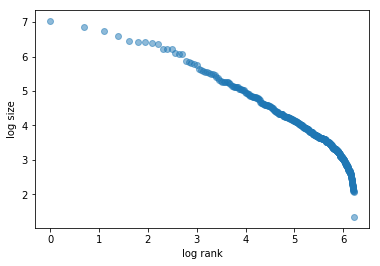

In [23]:
from scipy.stats import pareto, norm
import matplotlib.pyplot as plt
import numpy as np
    
log_size=np.sort(np.log(household))
log_size_rank=np.log(log_size.argsort()[::-1]+1)
fig, ax = plt.subplots()
    
ax.scatter(y=log_size,x=log_size_rank, marker='o', alpha=0.5)
ax.set_xlabel("log rank")
ax.set_ylabel("log size")

plt.show()

